Class and Function Define for RandomForest Regression

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


def load_and_preprocess_data(path):
    df = pd.read_csv(path)
    encoded_df = pd.get_dummies(df, columns=['District'], dtype=int)
    X = encoded_df[['pm25', 'pm10', 'o3', 'so2', 'no2', 'co']]
    y = encoded_df['AVG']
    Districts = ['District_강원도', 'District_경기도',  'District_경상남도', 'District_경상북도', 'District_광주광역시',  'District_대구광역시',  'District_대전광역시',  'District_부산광역시',  'District_서울특별시', 'District_세종특별자치시',  'District_울산광역시',  'District_인천광역시',  'District_전라남도', 'District_전라북도',  'District_제주특별자치도',  'District_충청남도',  'District_충청북도']
    scaler_x = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)
    X_scaled_with_districts = encoded_df[Districts].copy()
    X_scaled_with_districts[X.columns] = X_scaled
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))
    return X_scaled_with_districts, y_scaled


def train_and_evaluate(X, y, kfold, best_params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    y_train = y_train.ravel()
    model = RandomForestRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results = cross_val_score(model, X_train, y_train, cv=kfold)
    return mse, r2, results.mean(), results.std()


def main():
    path = 'data/semifinaldata_6.csv'
    X, y = load_and_preprocess_data(path)
    kfold = KFold(n_splits=11, random_state=0, shuffle=True) 
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [None, 5, 10],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4],  
        'max_features': ['auto', 'sqrt', 'log2']  
    }

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
'''
    A class that encapsulates the process of training a RandomForestRegressor model, from data preprocessing to model evaluation.
    '''
class RandomForestRegression:

    def __init__(self, data, predictors, target, districts):
        '''
        Run the entire process of data preparation, model training, and model evaluation.
        :param param_grid: The grid of parameters to search over
        :param test_size: The proportion of the data to be used as the test set
        :param cv: The number of folds for cross-validation
        :param kfold_splits: The number of folds for cross-validation in the model evaluation stage
        '''
        self.data = pd.read_csv(data)
        self.predictors = predictors
        self.target = target
        self.districts = districts
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.grid_search = None
        self.random_forest_model_best = None

    def prepare_data(self):
        '''
        Load the data and preprocess it, scaling the features and target variables.
        '''
        encoded_df = pd.get_dummies(self.data, columns=['District'], dtype=int)
        X = encoded_df[self.predictors]
        y = encoded_df[self.target]
        scaler_x = StandardScaler()
        X_scaled = scaler_x.fit_transform(X)
        X_scaled_with_districts = encoded_df[self.districts].copy()
        X_scaled_with_districts[X.columns] = X_scaled
        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))
        self.X = X_scaled_with_districts
        self.y = y_scaled.ravel()

    def split_data(self, test_size=0.3, random_state=0):
        '''
        Split the data into training and testing sets.
        :param test_size: The proportion of the data to be used as the test set
        :param random_state: The seed used by the random number generator
        '''
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

    def perform_grid_search(self, param_grid, cv=3):
        '''
        Perform a grid search to find the best parameters for the RandomForestRegressor model.
        :param param_grid: The grid of parameters to search over
        :param cv: The number of folds for cross-validation
        '''
        self.grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=cv)
        self.grid_search.fit(self.X_train, self.y_train)

    def fit_model(self):
        '''
        Fit the RandomForestRegressor model using the best parameters found in the grid search.
        '''
        best_params = self.grid_search.best_params_
        print("Best Parameters:", best_params)
        self.random_forest_model_best = RandomForestRegressor(**best_params)
        self.random_forest_model_best.fit(self.X_train, self.y_train)

    def evaluate_model(self, kfold_splits=11):
        '''
        Evaluate the RandomForestRegressor model by calculating the mean squared error and R-squared value, and by cross validation.
        :param kfold_splits: The number of folds for cross-validation
        '''
        y_pred_random_forest_best = self.random_forest_model_best.predict(self.X_test)
        mse_random_forest_best = mean_squared_error(self.y_test, y_pred_random_forest_best)
        r2_random_forest_best = r2_score(self.y_test, y_pred_random_forest_best)
        plt.scatter(self.y_test, y_pred_random_forest_best)
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.title("Random Forest Regression with best parameters")
        plt.plot([0, 1], [0, 1], color='red')
        plt.show()

        kfold = KFold(n_splits=kfold_splits, random_state=0, shuffle=True)
        results_random_forest_best = cross_val_score(self.random_forest_model_best, self.X_train, self.y_train, cv=kfold)

        print("Random Forest Regression Accuracy with best parameters: %.2f%% (%.2f%%)" % (results_random_forest_best.mean()*100, results_random_forest_best.std()*100))
        print(f"Random Forest Regression MSE with best parameters: {mse_random_forest_best}, R2 with best parameters: {r2_random_forest_best}")

    def feature_importance(self):
        """
        Extract and print the feature importances
        """
        # Check if the model is trained
        if self.random_forest_model_best is None:
            print("Model not trained yet.")
            return

        # Extract the feature importances
        feature_importances = self.random_forest_model_best.feature_importances_

        # Create a DataFrame for visualization
        importance_df = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': feature_importances
        })

        # Sort DataFrame by importance in descending order
        importance_df.sort_values('importance', ascending=False, inplace=True)

        # Display DataFrame
        print(importance_df)

    def predict_new_data(self, X_new):
        """
        Predict on new data with the trained model and return the original unscaled values
        """

        # Check if the model is trained
        if self.random_forest_model_best is None:
            print("Model not trained yet.")
            return

        # Specify the columns that need scaling
        cols_to_scale = ['pm25', 'pm10', 'o3', 'so2', 'no2', 'co']

        # Initialize a scaler
        scaler = StandardScaler()

        # Fit on the train data
        scaler.fit(self.X[cols_to_scale])

        # Create a copy of X_new for scaling
        X_new_scaled = X_new[cols_to_scale].copy()

        # Transform the new data
        X_new_scaled = scaler.transform(X_new_scaled)

        # Convert X_new_scaled to DataFrame to concatenate with Districts
        X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=cols_to_scale, index=X_new.index)

        # Concatenate scaled columns with Districts in X_new
        X_new_final = pd.concat([X_new[self.districts], X_new_scaled_df], axis=1)

        # Perform prediction with the trained model
        y_pred_new = self.random_forest_model_best.predict(X_new_final)

        # Reshape y_pred_new to 2D array
        y_pred_new_2D = y_pred_new.reshape(-1, 1)

        # Undo the scaling to get the original values
        y_pred_orig = self.scaler_y.inverse_transform(y_pred_new_2D)

        # Return the predicted values
        return y_pred_orig
    
    def find_best_kfold(self):
        """
        Find the best number of splits for K-Fold cross validation and visualize the cross-validation score versus number of folds
        """
        # Check if the model is trained
        if self.random_forest_model_best is None:
            print("Model not trained yet.")
            return

        # List to store scores
        scores_rf = []

        # K values to try
        k_values = range(2, 15)

        # For each K value...
        for k in k_values:
            # Create a KFold object
            kfold = KFold(n_splits=k, random_state=0, shuffle=True)

            # Apply k-Fold Cross Validation
            result_rf = cross_val_score(self.random_forest_model_best, self.X_train, self.y_train, cv=kfold)

            # Record average accuracy
            scores_rf.append(result_rf.mean())

        # Print the best K and its score for Random Forest Regression
        best_k_rf = k_values[scores_rf.index(max(scores_rf))]
        print(f"Best K for Random Forest Regression: {best_k_rf}, Accuracy: {max(scores_rf)*100:.2f}%")

        # Plotting the scores
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, scores_rf, marker='o', linestyle='dashed')
        plt.title('Cross-validation Score vs. number of folds')
        plt.xlabel('Number of folds')
        plt.ylabel('Cross-validation Score (R^2)')
        plt.grid()
        plt.show()
        
    def run(self, param_grid, test_size=0.3, cv=3, kfold_splits=11):
        '''
        Run the entire process of data preparation, model training, and model evaluation.
        :param param_grid: The grid of parameters to search over
        :param test_size: The proportion of the data to be used as the test set
        :param cv: The number of folds for cross-validation
        :param kfold_splits: The number of folds for cross-validation in the model evaluation stage
        '''
        self.prepare_data()
        self.split_data(test_size)
        self.perform_grid_search(param_grid, cv)
        self.fit_model()
        self.evaluate_model(kfold_splits)



Run Random Forest Regression & Evaluation1: Cross validation, MSE, R-squared

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


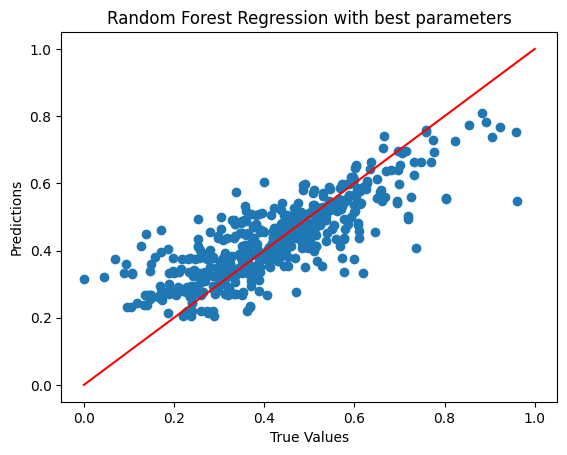

Random Forest Regression Accuracy with best parameters: 64.42% (5.08%)
Random Forest Regression MSE with best parameters: 0.008690463404303135, R2 with best parameters: 0.6527337282760497


In [11]:
data_path = 'data/semifinaldata_6.csv'
predictors = ['pm25', 'pm10', 'o3', 'so2', 'no2', 'co']
target = 'AVG'
districts = ['District_강원도', 'District_경기도',  'District_경상남도', 'District_경상북도', 'District_광주광역시',  'District_대구광역시',  'District_대전광역시',  'District_부산광역시',  'District_서울특별시', 'District_세종특별자치시',  'District_울산광역시',  'District_인천광역시',  'District_전라남도', 'District_전라북도',  'District_제주특별자치도',  'District_충청남도',  'District_충청북도']
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestRegression(data_path, predictors, target, districts)
model.run(param_grid, test_size=0.3, cv=3, kfold_splits=11)


Evaluation 2: K-Fold cross validation

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


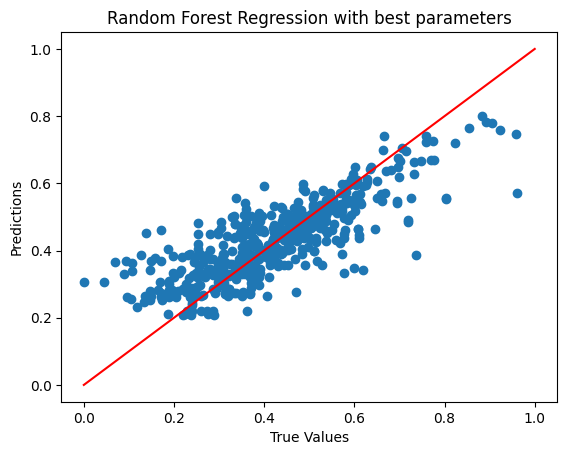

Random Forest Regression Accuracy with best parameters: 64.46% (5.41%)
Random Forest Regression MSE with best parameters: 0.008644873543799484, R2 with best parameters: 0.6545554747294874
Best K for Random Forest Regression: 14, Accuracy: 65.72%


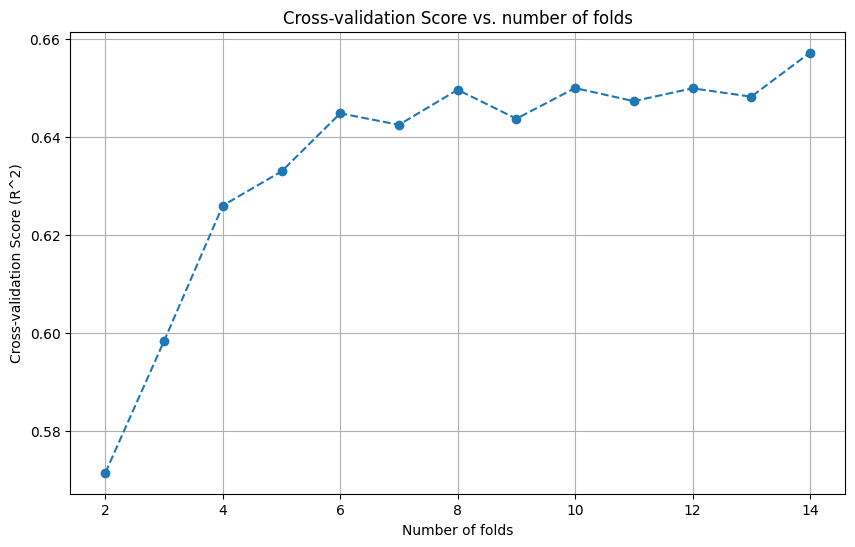

In [17]:
model = RandomForestRegression(data_path, predictors, target, districts)
model.run(param_grid, test_size=0.3, cv=3, kfold_splits=11)
model.find_best_kfold()

Evaluation 3: Feature Importance

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


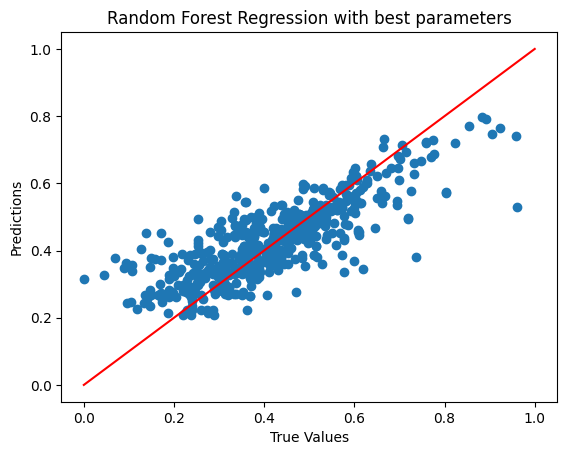

Random Forest Regression Accuracy with best parameters: 64.71% (5.58%)
Random Forest Regression MSE with best parameters: 0.00877813317406653, R2 with best parameters: 0.6492304911444653
             feature  importance
17              pm25    0.171540
18              pm10    0.152703
21               no2    0.150291
22                co    0.117555
19                o3    0.107048
20               so2    0.094232
1       District_경기도    0.091514
2      District_경상남도    0.020691
15     District_충청남도    0.017499
12     District_전라남도    0.013461
16     District_충청북도    0.010930
3      District_경상북도    0.009654
0       District_강원도    0.009164
8     District_서울특별시    0.009136
13     District_전라북도    0.006529
14  District_제주특별자치도    0.003608
9   District_세종특별자치시    0.003505
11    District_인천광역시    0.002844
6     District_대전광역시    0.002486
7     District_부산광역시    0.001873
5     District_대구광역시    0.001529
4     District_광주광역시    0.001487
10    District_울산광역시    0.000719


In [14]:
model = RandomForestRegression(data_path, predictors, target, districts)
model.run(param_grid, test_size=0.3, cv=3, kfold_splits=11)
model.feature_importance()